# Iterate Over Full Dataset

In [1]:
import os

from infmidi import Midi

In [2]:
midi_files_dict = {}

for i, os_walk_tuple in enumerate(os.walk('../../data/midi_files/')):
    files_list = os_walk_tuple[2]
    
    for filename in files_list:
        directory = os_walk_tuple[0]

        if filename[-3:] == 'mid':
            midi_files_dict[filename] = Midi.read(os.path.join(directory, filename))

In [3]:
from typing import Dict, Union

from torch.utils.data import Dataset, DataLoader


class MIDIFilesDataset(Dataset):
    def __init__(self, midi_files_dict: Dict[str, str]):
        self._midi_files_dict = midi_files_dict
        self._midi_files_dict_keys = list(self._midi_files_dict.keys())

    def __getitem__(self, idx: Union[str, int]):
        if type(idx) in [int, str]:     
            if type(idx) is int: 
                if idx > len(self): raise IndexError
                else: str_idx = self._midi_files_dict_keys[idx]
                                    
            if type(idx) is str:
                if not idx in self._midi_files_dict: raise IndexError
                else: str_idx = idx

            return str_idx, self._midi_files_dict[str_idx]

        else: raise IndexError

    def __len__(self):
        return len(self._midi_files_dict)    

In [4]:
midi_files_dataset = MIDIFilesDataset(midi_files_dict)

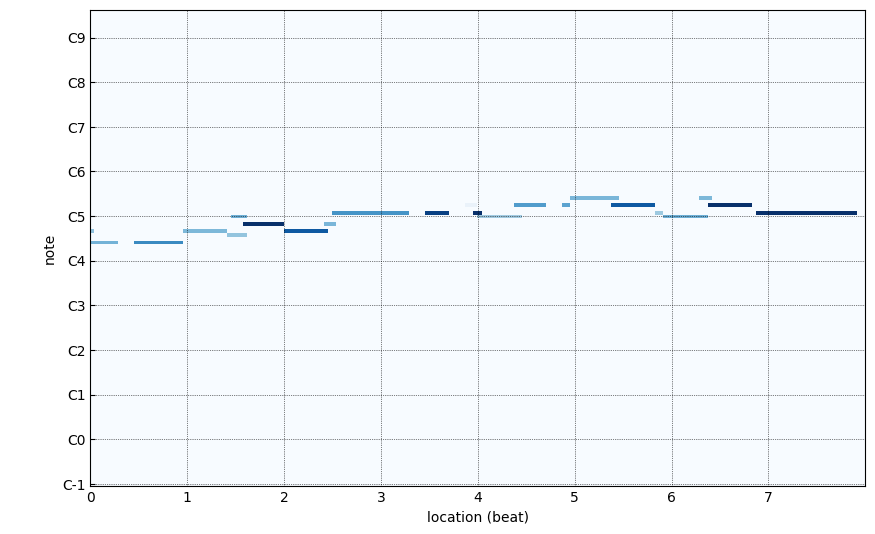

In [5]:
from infmidi import plot

test_midi_file_name = 'Sargam Geet - Antra 1.2.mid'
test_midi = midi_files_dataset[test_midi_file_name][1]

plot(test_midi)

## Converting to Tensors

In [6]:
test_midi.tracks[0].notes

NoteSet([
  Note(name="G#4", value=68, frequency=415.30, velocity=52, length=0.09, location=0.00, channel=0),
  Note(name="F4", value=65, frequency=349.23, velocity=61, length=0.33, location=0.01, channel=0),
  Note(name="F4", value=65, frequency=349.23, velocity=83, length=0.53, location=0.47, channel=0),
  Note(name="G#4", value=68, frequency=415.30, velocity=58, length=0.50, location=0.97, channel=0),
  Note(name="G4", value=67, frequency=392.00, velocity=51, length=0.25, location=1.44, channel=0),
  Note(name="C5", value=72, frequency=523.25, velocity=63, length=0.22, location=1.47, channel=0),
  Note(name="A#4", value=70, frequency=466.16, velocity=127, length=0.47, location=1.59, channel=0),
  Note(name="G#4", value=68, frequency=415.30, velocity=107, length=0.50, location=2.00, channel=0),
  Note(name="A#4", value=70, frequency=466.16, velocity=59, length=0.16, location=2.44, channel=0),
  Note(name="C#5", value=73, frequency=554.37, velocity=78, length=0.81, location=2.53, chan

In [7]:
import numpy as np


def convert_midi_to_np_array(midi: Midi) -> np.array:
    ticks_per_beat = midi.ticks_per_beat
    
    array = np.zeros((midi.length*ticks_per_beat, 128), dtype=np.uint8)

    for note in midi.tracks[0].notes:
        note_start = int(note.location*ticks_per_beat)
        note_end = note_start + int(note.length*ticks_per_beat)

        array[note_start:note_end, note.value] = note.velocity

    return array

In [8]:
convert_midi_to_np_array(test_midi)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(768, 128), dtype=uint8)

## Verify that 2 events never happen at the same timestep

In [12]:
for file_name, midi in midi_files_dataset:
    note_on_events =  [note.location for note in midi.tracks[0].notes]

    if not len(set(note_on_events)) == len(note_on_events):
        print(f'{file_name} has multiple NOTE ON events at one timestep')
        print()

# Verify Notes are in C# Yaman

In [170]:
from infmidi.utils import plot

In [180]:
yaman_c_sharp = ['C#', 'D#', 'F', 'G', 'G#', 'A#', 'C']

yaman_c_sharp_midi = [
    note + octave
    for octave in [str(e) for e in list(range(8))]
    for note in yaman_c_sharp
]

In [181]:
exist_bad_melodies = False

for midi_file in midi_files_dataset:
    if not all([note.name in yaman_c_sharp_midi for note in midi_melody.tracks[0].notes]):
        print(f'Bad Melody: {midi_file.name}!')
        exist_bad_melodies = True
        break

if not exist_bad_melodies:
    print('All melodies are in C# Yaman!')

All melodies are in C# Yaman!


# Verify Lowest Resolution (Ticks)

In [205]:
import math

import numpy as np


test_resolution = 96  # (ticks per beat)
epsilon = 1e-6
is_resolution_good = True

for midi_melody in midi_files_dataset:
    note_locations = np.array([note.location for note in midi_melody.tracks[0].notes])
    note_locations, _ = np.modf(note_locations)
    note_locations = note_locations * test_resolution
    note_locations = np.abs(note_locations - np.round(note_locations))
    note_locations[np.abs(note_locations) < epsilon] = 0.0

    if not np.all(note_locations == 0.0):
        print(f'Resolution needs to be finer for {midi_file}\nwith notes:\n{midi_melody.tracks[0].notes}\n')

        ##################
        ### DEBUGGING ###
        ##################
        note_locations = np.array([note.location for note in midi_melody.tracks[0].notes])
        print(f'Absolute note locations:\n{note_locations}\n')
        note_locations, _ = np.modf(note_locations)
        print(f'Note locations relative to last beat:\n{note_locations}\n')
        note_locations = note_locations * test_resolution
        print(f'Note locations relative to last beat in ticks (at {test_resolution} ticks per beat):\n{note_locations}\n')
        note_locations = np.abs(note_locations - np.round(note_locations))
        note_locations[np.abs(note_locations) < epsilon] = 0.0
        print(f'Note locations relative to last tick (at {test_resolution} ticks per beat):\n {note_locations}\n')
        print()
        print()
        
        is_resolution_good = False
        break

if is_resolution_good:
    print(f'Resolution of {test_resolution} is good')

Resolution of 96 is good


# Verify with Playback

In [107]:
from infmidi.devices import FluidSynth

synth = FluidSynth()

synth(midi_melody)

ALSA lib seq_hw.c:466:(snd_seq_hw_open) open /dev/snd/seq failed: No such file or directory
fluidsynth: error: Error opening ALSA sequencer
Failed to create the MIDI thread; no MIDI input
will be available. You can access the synthesizer 
through the console.
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
exec of JACK server (command = "/usr/bin/jackd") failed: No such file or directory
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.



jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
fluidsynth: error: Failed to connect to Jack server.
Failed to create the audio driver
